In [1]:
def calculate_kan_parameters(layers_hidden, grid_size, spline_order, enable_scaler=False):
    """
    Calcola il numero totale di parametri per una rete KAN fully connected.

    Args:
        layers_hidden (list): Numero di neuroni per ciascun layer, inclusi input e output.
        grid_size (int): Dimensione della griglia della spline.
        spline_order (int): Ordine della spline.
        enable_scaler (bool): Se True, considera anche i parametri scaler.

    Returns:
        int: Numero totale di parametri.
    """
    total_params = 0
    for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
        base_params = in_features * out_features
        spline_params = in_features * out_features * (grid_size + spline_order)
        scaler_params = in_features * out_features if enable_scaler else 0
        total_params += base_params + spline_params + scaler_params
    return total_params


def calculate_mlp_parameters(layers_hidden):
    """
    Calcola il numero totale di parametri per una rete fully connected standard (MLP).

    Args:
        layers_hidden (list): Numero di neuroni per ciascun layer, inclusi input e output.

    Returns:
        int: Numero totale di parametri.
    """
    total_params = 0
    for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
        base_params = in_features * out_features
        bias_params = out_features  # Bias per ogni neurone di output
        total_params += base_params + bias_params
    return total_params


def compare_kan_mlp(layers_hidden, grid_size, spline_order, enable_scaler=False):
    """
    Confronta il numero di parametri tra una rete KAN e una MLP.

    Args:
        layers_hidden (list): Numero di neuroni per ciascun layer, inclusi input e output.
        grid_size (int): Dimensione della griglia per le spline.
        spline_order (int): Ordine delle spline.
        enable_scaler (bool): Se True, considera i parametri scaler nelle KAN.

    Returns:
        None: Stampa i risultati.
    """
    kan_params = calculate_kan_parameters(layers_hidden, grid_size, spline_order, enable_scaler)
    mlp_params = calculate_mlp_parameters(layers_hidden)
    difference = kan_params - mlp_params
    ratio = kan_params / mlp_params if mlp_params > 0 else float('inf')

    print(f"Numero di parametri KAN: {kan_params}")
    print(f"Numero di parametri MLP: {mlp_params}")
    print(f"Differenza (KAN - MLP): {difference}")
    print(f"Rapporto (KAN / MLP): {ratio:.2f}")

# Esempio
layers_hidden = [784, 300, 100, 10]  # Struttura della rete
grid_size = 5  # Dimensione della griglia
spline_order = 3  # Ordine delle spline
enable_scaler = True  # Considera i parametri scaler opzionali

compare_kan_mlp(layers_hidden, grid_size, spline_order, enable_scaler)


Numero di parametri KAN: 2662000
Numero di parametri MLP: 266610
Differenza (KAN - MLP): 2395390
Rapporto (KAN / MLP): 9.98


In [11]:
from architectures_28x28.KANLinearFullyConnected import KANLinearFullyConnected 
import os
import inspect
import argparse
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
import pandas as pd
import matplotlib.pyplot as plt
import struct
from scipy.interpolate import BSpline
import re
import imageio.v2 as imageio
from concurrent.futures import ThreadPoolExecutor

def load_model(model_path, model_class, model_args):
    """
    Carica un modello KAN salvato come checkpoint.
    
    Args:
        model_path (str): Percorso del file salvato.
        model_class: Classe del modello.
        model_args (dict): Argomenti per istanziare il modello.
    
    Returns:
        torch.nn.Module: Modello ricostruito con i pesi caricati.
    """
    # Ricrea il modello utilizzando la classe e gli argomenti
    model = model_class(**model_args)
    
    # Carica il checkpoint e accedi al model_state_dict
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Imposta in modalità di valutazione
    return model



def load_models_from_folder(model_folder, model_class, model_args, max_workers=4):
    """
    Carica modelli KAN da una cartella specificata in parallelo e restituisce un array di modelli.

    Args:
        model_folder (str): Percorso della cartella contenente i checkpoint.
        model_class: Classe del modello.
        model_args (dict): Argomenti per istanziare il modello.
        max_workers (int): Numero massimo di thread paralleli (default: 4).

    Returns:
        list: Lista di modelli caricati.
    """
    # Trova i checkpoint disponibili
    checkpoint_files = [
        f for f in os.listdir(model_folder) if re.match(r'checkpoint_epoch_(\d+)\.pth', f)
    ]

    # Estrarre i numeri di epoch dai nomi dei file
    epoch_numbers = sorted(
        int(re.match(r'checkpoint_epoch_(\d+)\.pth', f).group(1)) for f in checkpoint_files
    )

    if not epoch_numbers:
        raise ValueError("Nessun checkpoint trovato nella cartella specificata.")

    print(f"Checkpoint trovati: da epoch {min(epoch_numbers)} a epoch {max(epoch_numbers)}")

    # Funzione per caricare un modello dato il suo epoch
    def load_model_for_epoch(epoch):
        model_path = os.path.join(model_folder, f"checkpoint_epoch_{epoch}.pth")
        return load_model(model_path, model_class, model_args)

    # Caricare i modelli in parallelo
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        models = list(executor.map(load_model_for_epoch, epoch_numbers))

    print(f"Numero di modelli caricati: {len(models)}")
    return models

    
def compute_spline(x, grid, weights, order):
    """
    Computes the value of the B-spline at given points x.

    Args:
        x (numpy.ndarray): Points where to evaluate the spline.
        grid (numpy.ndarray): Knot vector.
        weights (numpy.ndarray): Spline coefficients.
        order (int): Order of the spline.

    Returns:
        tuple: (Evaluated spline values at points x, augmented knots, degree)
    """
    try:
        x = x.squeeze(-1).numpy()
        knots = grid
        degree = order

        # Ensure that the number of knots is equal to len(weights) + degree + 1
        n_knots_needed = len(weights) + degree + 1
        if len(knots) < n_knots_needed:
            # Augment knots by repeating the first and last knots as needed
            knots = np.concatenate((
                np.full(degree, knots[0]),
                knots,
                np.full(degree, knots[-1])
            ))
        spline = BSpline(knots, weights, degree)
        y = spline(x)
        return y, knots, degree
    except Exception as e:
        print(f"ERROR in compute_spline: {str(e)}")
        raise

def plot_spline_for_neuron(model, layer_idx, in_neuron_idx, out_neuron_idx, grid_range=(-1, 1)):
    """
    Generates plots of the learned splines with their control points, including debug statements.

    Args:
        model: Loaded KAN model.
        layer_idx: Index of the selected layer.
        in_neuron_idx: Index of the neuron in the previous layer.
        out_neuron_idx: Index of the neuron in the current layer.
        grid_range: Range of the grid for the splines.
    """
    try:
        # Select the layer
        layer = model.layers[layer_idx]  
        
        # Extract the grid and weights
        grid = layer.grid[in_neuron_idx].detach().cpu().numpy()  # Grid of the spline
        spline_weights = layer.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()  # Spline weights
        
        # Generate x points for the extended spline
        x_extended = torch.linspace(grid_range[0], grid_range[1], 500).unsqueeze(1)

        
        # Compute the spline and get knots and degree
        y_extended, knots, degree = compute_spline(x_extended, grid, spline_weights, layer.spline_order)


        # Compute Greville abscissae
        greville_abscissae = np.array([
            np.sum(knots[i+1:i+degree+1]) / degree for i in range(len(spline_weights))
        ])

        # Generate the plot
        plt.figure(figsize=(8, 6))
        plt.plot(x_extended.numpy().flatten(), y_extended, label="Spline")
        plt.scatter(greville_abscissae, spline_weights, color="red", zorder=5, label="Control Points")
        plt.axvline(grid_range[0], color='r', linestyle='--', label="Grid Limits")
        plt.axvline(grid_range[1], color='r', linestyle='--')
        plt.title(f"Spline for Layer {layer_idx}, Neuron {in_neuron_idx} -> Neuron {out_neuron_idx}")
        plt.xlabel("Input")
        plt.ylabel("Spline Output")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"ERROR in plot_spline_for_neuron: {str(e)}")
        raise

def calculate_ylim(models, layer_idx, in_neuron_idx, out_neuron_idx, grid_range=(-1, 1)):
    """
    Calculate the y-axis limits based on the lowest and highest spline values across all models.

    Args:
        models: List of KAN models.
        layer_idx: Index of the selected layer.
        in_neuron_idx: Index of the neuron in the previous layer.
        out_neuron_idx: Index of the neuron in the current layer.
        grid_range: Range of the grid for the splines.

    Returns:
        tuple: (min_y, max_y) representing the y-axis limits.
    """
    min_y = float('inf')  # Initialize to a very large value
    max_y = float('-inf') # Initialize to a very small value

    x_extended = torch.linspace(grid_range[0], grid_range[1], 500).unsqueeze(1)

    for model in models:
        try:
            # Select the layer
            layer = model.layers[layer_idx]

            # Extract grid and weights
            grid = layer.grid[in_neuron_idx].detach().cpu().numpy()
            spline_weights = layer.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()

            # Compute the spline values
            y_extended, _, _ = compute_spline(x_extended, grid, spline_weights, layer.spline_order)

            # Update global min and max
            min_y = min(min_y, y_extended.min())
            max_y = max(max_y, y_extended.max())
        
        except Exception as e:
            print(f"ERROR in calculate_ylim for model: {str(e)}")
            continue

    return min_y, max_y


def collect_spline_statistics_for_single_model(model, layer_idx, in_neuron_idx, out_neuron_idx, grid_range=(-1, 1)):
    """
    Raccoglie statistiche dettagliate su una spline specifica in un determinato modello.

    Args:
        model: Modello KAN su cui calcolare le statistiche.
        layer_idx: Indice del layer selezionato.
        in_neuron_idx: Indice del neurone nel layer precedente.
        out_neuron_idx: Indice del neurone nel layer corrente.
        grid_range: Intervallo della griglia per calcolare i valori della spline.

    Returns:
        dict: Statistiche raccolte, tra cui valor medio, varianza, minimo, massimo, ampiezza picco-picco e deviazione standard.
    """
    try:
        # Seleziona il layer
        layer = model.layers[layer_idx]

        # Estrai la griglia e i pesi della spline
        grid = layer.grid[in_neuron_idx].detach().cpu().numpy()
        spline_weights = layer.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()

        # Genera i punti x per valutare la spline
        x_extended = torch.linspace(grid_range[0], grid_range[1], 500).unsqueeze(1)

        # Calcola i valori della spline
        y_extended, _, _ = compute_spline(x_extended, grid, spline_weights, layer.spline_order)

        # Converti in numpy array per calcoli statistici
        y_values = y_extended.flatten()

        # Calcola le statistiche
        statistics = {
            "mean": np.mean(y_values),
            "variance": np.var(y_values),
            "min": np.min(y_values),
            "max": np.max(y_values),
            "peak_to_peak": np.ptp(y_values),  # Max - Min
            "std_dev": np.std(y_values),      # Deviazione standard
        }

        return statistics

    except Exception as e:
        print(f"ERROR in collect_spline_statistics_for_single_model: {str(e)}")
        return None

def collect_layer_statistics(model, layer_idx, grid_range=(-1, 1)):
    """
    Calcola statistiche medie per tutte le spline di un layer in un modello.

    Args:
        model: Modello KAN su cui calcolare le statistiche.
        layer_idx: Indice del layer selezionato.
        grid_range: Intervallo della griglia per calcolare i valori della spline.

    Returns:
        dict: Statistiche mediate sul layer, tra cui valor medio, varianza, minimo, massimo,
              ampiezza picco-picco e deviazione standard.
    """
    try:
        # Seleziona il layer
        layer = model.layers[layer_idx]

        # Ottieni il numero di neuroni in ingresso e in uscita
        num_in_neurons = layer.grid.size(0)
        num_out_neurons = layer.spline_weight.size(0)

        # Inizializza accumulatori per le statistiche
        accumulated_statistics = {
            "mean": 0.0,
            "variance": 0.0,
            "min": 0.0,
            "max": 0.0,
            "peak_to_peak": 0.0,
            "std_dev": 0.0,
        }
        count = 0  # Conta il numero di spline processate

        # Itera su tutti i neuroni in ingresso e in uscita
        for in_neuron_idx in range(num_in_neurons):
            for out_neuron_idx in range(num_out_neurons):
                # Ottieni le statistiche per la singola spline
                stats = collect_spline_statistics_for_single_model(
                    model, layer_idx, in_neuron_idx, out_neuron_idx, grid_range
                )
                if stats is not None:
                    # Accumula le statistiche
                    for key in accumulated_statistics:
                        accumulated_statistics[key] += stats[key]
                    count += 1

        # Calcola la media per ogni statistica
        if count > 0:
            for key in accumulated_statistics:
                accumulated_statistics[key] /= count

        return accumulated_statistics

    except Exception as e:
        print(f"ERROR in collect_layer_statistics: {str(e)}")
        return None
def collect_network_statistics_single_model(model, grid_range=(-1, 1)):
    """
    Calcola le statistiche medie per tutti i layer e neuroni di un singolo modello.

    Args:
        model: Modello KAN su cui calcolare le statistiche.
        grid_range: Intervallo della griglia per calcolare i valori della spline.

    Returns:
        dict: Statistiche mediate per tutta la rete, contenente i valori medi, 
              varianza, minimo, massimo, ampiezza picco-picco e deviazione standard.
    """
    try:
        # Inizializza accumulatori per tutte le statistiche
        accumulated_network_statistics = {
            "mean": 0.0,
            "variance": 0.0,
            "min": 0.0,
            "max": 0.0,
            "peak_to_peak": 0.0,
            "std_dev": 0.0,
        }
        total_splines = 0  # Conta il numero totale di spline processate

        # Itera su tutti i layer del modello
        for layer_idx in range(len(model.layers)):
            # Ottieni le statistiche medie per il layer
            layer_statistics = collect_layer_statistics(model, layer_idx, grid_range)

            if layer_statistics:
                # Accumula le statistiche del layer
                for key in accumulated_network_statistics:
                    accumulated_network_statistics[key] += layer_statistics[key]
                # Aggiungi il numero di spline del layer al conteggio totale
                num_in_neurons = model.layers[layer_idx].grid.size(0)
                num_out_neurons = model.layers[layer_idx].spline_weight.size(0)
                total_splines += num_in_neurons * num_out_neurons

        # Calcola la media per ogni statistica per la rete
        if total_splines > 0:
            for key in accumulated_network_statistics:
                accumulated_network_statistics[key] /= total_splines

        return accumulated_network_statistics

    except Exception as e:
        print(f"ERROR in collect_network_statistics_single_model: {str(e)}")
        return None

def collect_statistics_for_models(models, grid_range=(-1, 1)):
    """
    Calcola le statistiche per ogni modello in una lista di modelli.

    Args:
        models: Lista di modelli KAN su cui calcolare le statistiche.
        grid_range: Intervallo della griglia per calcolare i valori della spline.

    Returns:
        list[dict]: Lista di dizionari, ciascuno contenente le statistiche per un modello.
    """
    try:
        all_statistics = []

        # Itera sui modelli
        for idx, model in enumerate(models):
            print(f"Calcolo delle statistiche per il modello {idx + 1}/{len(models)}...")
            # Usa la funzione per calcolare le statistiche per un singolo modello
            model_statistics = collect_network_statistics_single_model(model, grid_range)
            
            # Salva le statistiche del modello nella lista
            if model_statistics:
                all_statistics.append(model_statistics)
            else:
                print(f"Errore durante il calcolo delle statistiche per il modello {idx + 1}.")

        return all_statistics

    except Exception as e:
        print(f"ERROR in collect_statistics_for_models: {str(e)}")
        return None

def collect_statistics_for_models_parallel(models, grid_range=(-1, 1), max_workers=4):
    """
    Calcola le statistiche per ogni modello in parallelo.

    Args:
        models: Lista di modelli KAN su cui calcolare le statistiche.
        grid_range: Intervallo della griglia per calcolare i valori della spline.
        max_workers: Numero massimo di thread paralleli.

    Returns:
        list[dict]: Lista di dizionari, ciascuno contenente le statistiche per un modello.
    """
    all_statistics = []

    def calculate_statistics_for_model(model, idx):
        """Funzione wrapper per calcolare le statistiche per un singolo modello."""
        print(f"Calcolo delle statistiche per il modello {idx + 1} in parallelo...")
        return collect_network_statistics_single_model(model, grid_range)

    # Usa ThreadPoolExecutor per parallelizzare
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {
            executor.submit(calculate_statistics_for_model, model, idx): idx
            for idx, model in enumerate(models)
        }

        for future in as_completed(future_to_model):
            idx = future_to_model[future]
            try:
                result = future.result()
                if result:
                    all_statistics.append(result)
                else:
                    print(f"Errore durante il calcolo delle statistiche per il modello {idx + 1}.")
            except Exception as e:
                print(f"Errore durante l'elaborazione del modello {idx + 1}: {str(e)}")

    return all_statistics

def print_statistics_table(models, grid_range=(-1, 1), max_workers=4):
    """
    Calcola e stampa una tabella contenente i valori delle statistiche per i modelli.

    Args:
        models: Lista di modelli KAN su cui calcolare le statistiche.
        grid_range: Intervallo della griglia per calcolare i valori della spline.
    """
    try:
        # Calcola le statistiche per ogni modello
        models_statistics = collect_statistics_for_models(models, grid_range=(-1, 1))

        if not models_statistics:
            print("Nessuna statistica calcolata.")
            return

        # Prepara i dati per la tabella
        table_data = []
        for idx, stats in enumerate(models_statistics, start=1):
            row = {'Model': f"Model {idx}"}
            row.update(stats)
            table_data.append(row)

        # Crea un DataFrame per visualizzare i dati
        df = pd.DataFrame(table_data)

        # Print the table in a clean format
        print("\nStatistiche per i modelli:")
        print(df.to_string(index=False))

        return df
    except Exception as e:
        print(f"ERROR in print_statistics_table: {str(e)}")

def compare_splines_for_neuron(
    model1, model2, layer_idx, in_neuron_idx, out_neuron_idx, grid_range=(-1, 1), 
    plot_control_points=True, model_index1=1, model_index2=2, save_path=None, y_min = -0.0015 , y_max = 0.0015
):
    """
    Generates plots of the learned splines for the same layer and neuron pair in two models.

    Args:
        model1: First KAN model.
        model2: Second KAN model.
        layer_idx: Index of the selected layer.
        in_neuron_idx: Index of the neuron in the previous layer.
        out_neuron_idx: Index of the neuron in the current layer.
        grid_range: Range of the grid for the splines.
        plot_control_points: If True, plots the control points (default: True).
        model_index1: Index of the first model for labeling.
        model_index2: Index of the second model for labeling.
        save_path: If provided, saves the plot to the specified path (default: None).
    """
    try:
        # Select the layers
        layer1 = model1.layers[layer_idx]
        layer2 = model2.layers[layer_idx]
        
        # Extract the grids and weights for both models
        grid1 = layer1.grid[in_neuron_idx].detach().cpu().numpy()
        spline_weights1 = layer1.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()
        
        grid2 = layer2.grid[in_neuron_idx].detach().cpu().numpy()
        spline_weights2 = layer2.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()
        
        # Generate x points for the extended spline
        x_extended = torch.linspace(grid_range[0], grid_range[1], 500).unsqueeze(1)
        
        # Compute the splines and get knots and degrees for both models
        y_extended1, knots1, degree1 = compute_spline(x_extended, grid1, spline_weights1, layer1.spline_order)
        y_extended2, knots2, degree2 = compute_spline(x_extended, grid2, spline_weights2, layer2.spline_order)
        
        # Compute Greville abscissae for both models
        greville_abscissae1 = np.array([
            np.sum(knots1[i+1:i+degree1+1]) / degree1 for i in range(len(spline_weights1))
        ])
        greville_abscissae2 = np.array([
            np.sum(knots2[i+1:i+degree2+1]) / degree2 for i in range(len(spline_weights2))
        ])

        # Generate the plot
        plt.figure(figsize=(10, 6))  # Aumenta la dimensione del plot per spazio alla legenda
        plt.plot(x_extended.numpy().flatten(), y_extended1, label=f"Model {model_index1} - Spline", color="blue")
        plt.plot(x_extended.numpy().flatten(), y_extended2, label=f"Model {model_index2} - Spline", color="green")

        # Plot control points only if the parameter is True
        if plot_control_points:
            plt.scatter(greville_abscissae1, spline_weights1, color="red", zorder=5, label=f"Model {model_index1} - Control Points")
            plt.scatter(greville_abscissae2, spline_weights2, color="orange", zorder=5, label=f"Model {model_index2} - Control Points")
        
        # Set fixed axis limits
        plt.xlim(grid_range[0] * 1.10, grid_range[1]*1.10)
        plt.ylim(y_min, y_max)

        # Add grid lines
        plt.grid(True)

        # Position the legend outside the plot on the right
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # Sposta la legenda fuori dal grafico
        
        plt.title(f"Spline Comparison for Layer {layer_idx}, Neuron {in_neuron_idx} -> Neuron {out_neuron_idx}")
        plt.xlabel("Input")
        plt.ylabel("Spline Output")
        plt.tight_layout()  # Adatta il layout per non tagliare la legenda

        # Save or show the plot
        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
            plt.close()
            print(f"Grafico salvato in: {save_path}")
        else:
            plt.show()
    except Exception as e:
        print(f"ERROR in compare_splines_for_neuron: {str(e)}")
        raise



def find_max_spline_difference(model1, model2):
    """
    Trova la coppia di neuroni (layer, neurone precedente, neurone successivo) 
    con la massima differenza tra i control point delle spline tra due modelli.

    Args:
        model1: Primo modello KAN caricato.
        model2: Secondo modello KAN caricato.

    Returns:
        tuple: (layer_idx, in_neuron_idx, out_neuron_idx, max_difference)
    """
    max_difference = 0
    max_indices = (-1, -1, -1)  # (layer_idx, in_neuron_idx, out_neuron_idx)

    # Itera sui layer
    for layer_idx, (layer1, layer2) in enumerate(zip(model1.layers, model2.layers)):
        # Assumi che il numero di neuroni e spline sia identico nei due modelli
        num_in_neurons = layer1.grid.size(0)
        num_out_neurons = layer1.spline_weight.size(0)

        # Itera sui neuroni in ingresso e uscita
        for in_neuron_idx in range(num_in_neurons):
            for out_neuron_idx in range(num_out_neurons):
                # Estrai i control point (pesi) delle spline per entrambi i modelli
                control_points1 = layer1.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()
                control_points2 = layer2.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()

                # Calcola la distanza tra i control point (norma L2)
                difference = np.linalg.norm(control_points1 - control_points2)

                # Aggiorna il massimo se necessario
                if difference > max_difference:
                    max_difference = difference
                    max_indices = (layer_idx, in_neuron_idx, out_neuron_idx)

    return max_indices + (max_difference,)

def find_max_excursion(model, grid_range=(-1, 1)):
    """
    Trova la tripla (layer_idx, in_neuron_idx, out_neuron_idx) nel modello che presenta
    la massima escursione di valori (max - min) della spline.

    Args:
        model: Il modello KAN in cui cercare.
        grid_range: Range della griglia per la spline.

    Returns:
        tuple: (layer_idx, in_neuron_idx, out_neuron_idx, max_excursion)
               con la massima escursione.
    """
    max_excursion = float('-inf')  # Inizializza a un valore molto basso
    max_indices = (-1, -1, -1)    # Placeholder per layer, neurone precedente, neurone successivo

    x_extended = torch.linspace(grid_range[0], grid_range[1], 500).unsqueeze(1)

    # Itera sui layer del modello
    for layer_idx, layer in enumerate(model.layers):
        num_in_neurons = layer.grid.size(0)  # Numero di neuroni in ingresso
        num_out_neurons = layer.spline_weight.size(0)  # Numero di neuroni in uscita

        # Itera sui neuroni in ingresso e uscita
        for in_neuron_idx in range(num_in_neurons):
            for out_neuron_idx in range(num_out_neurons):
                try:
                    # Estrai griglia e pesi
                    grid = layer.grid[in_neuron_idx].detach().cpu().numpy()
                    spline_weights = layer.spline_weight[out_neuron_idx, in_neuron_idx].detach().cpu().numpy()

                    # Calcola i valori della spline
                    y_extended, _, _ = compute_spline(x_extended, grid, spline_weights, layer.spline_order)

                    # Calcola l'escursione per questa connessione
                    excursion = y_extended.max() - y_extended.min()

                    # Aggiorna il massimo se necessario
                    if excursion > max_excursion:
                        max_excursion = excursion
                        max_indices = (layer_idx, in_neuron_idx, out_neuron_idx)
                
                except Exception as e:
                    print(f"ERROR in find_max_excursion for connection: {str(e)}")
                    continue

    return max_indices + (max_excursion,)

def create_variable_speed_gif(output_folder, gif_name="spline_comparisons_variable_speed.gif", max_duration=1.0, min_duration=0.1, fps=10):
    """
    Genera una GIF da una cartella di immagini, con velocità variabile (più lenta all'inizio e più veloce alla fine).

    Args:
        output_folder (str): Percorso della cartella contenente le immagini.
        gif_name (str): Nome del file GIF da salvare (default: "spline_comparisons_variable_speed.gif").
        max_duration (float): Durata massima iniziale per ogni frame (in secondi, default: 1.0).
        min_duration (float): Durata minima finale per ogni frame (in secondi, default: 0.1).
        fps (int): Frame per secondo, usato per simulare durate variabili (default: 10).
    """
    # Percorso completo del file GIF
    gif_path = os.path.join(output_folder, gif_name)

    # Recupera tutte le immagini dalla cartella
    image_files = [
        os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".png")
    ]

    # Ordina le immagini in base al valore di x nel nome del file
    def extract_x_from_filename(filename):
        match = re.search(r"_model_(\d+)_vs", filename)
        return int(match.group(1)) if match else float('inf')  # Inf se il pattern non viene trovato

    image_files.sort(key=extract_x_from_filename)

    # Genera una lista di durate: più lenta all'inizio, più veloce alla fine (quadratica)
    num_images = len(image_files)
    durations = max_duration - (np.linspace(0, 1, num_images) ** 2) * (max_duration - min_duration)

    # Crea la GIF con durate simulate tramite frame ripetuti
    with imageio.get_writer(gif_path, mode="I", fps=fps) as writer:
        for image_file, duration in zip(image_files, durations):
            # Calcola quante volte ripetere il frame per simulare la durata
            repeat_count = max(1, int(duration * fps))  # Almeno una ripetizione
            frame = imageio.imread(image_file)
            for _ in range(repeat_count):
                writer.append_data(frame)  # Aggiungi frame ripetuti

    # Calcola la durata totale della GIF
    total_duration = sum(durations)
    print(f"GIF creata con durata totale: {total_duration:.2f} secondi")
    print(f"GIF salvata in: {gif_path}")



def generate_spline_comparisons(
    models, 
    layer_idx, 
    in_neuron_idx, 
    out_neuron_idx, 
    grid_range=(-1, 1), 
    output_folder="spline_comparisons"
):
    """
    Genera confronti delle spline per una specifica connessione tra due modelli consecutivi 
    e salva i plot in una cartella specificata.

    Args:
        models (list): Lista di modelli KAN.
        layer_idx (int): Indice del livello da confrontare.
        in_neuron_idx (int): Indice del neurone nel livello precedente.
        out_neuron_idx (int): Indice del neurone nel livello successivo.
        grid_range (tuple): Range dei valori per le x delle spline (default: (-1, 1)).
        output_folder (str): Percorso della cartella di output in cui salvare i plot (default: "spline_comparisons").
    """
    # Crea la cartella di output se non esiste
    os.makedirs(output_folder, exist_ok=True)
    
    # Calcola i limiti delle y per il grafico
    y_min, y_max = calculate_ylim(models, layer_idx, in_neuron_idx, out_neuron_idx, grid_range)
    print(f"Y-limits calcolati: {y_min}, {y_max}")

    # Itera sui modelli consecutivi e salva i plot
    for i in range(len(models) - 1):
        model1 = models[i]
        model2 = models[i + 1]

        # Percorso del file per il plot corrente
        save_path = os.path.join(output_folder, f"spline_comparison_model_{i+1}_vs_{i+2}.png")
        print(f"Salvando il plot: {save_path}")

        # Genera e salva il plot
        compare_splines_for_neuron(
            model1=model1, 
            model2=model2, 
            layer_idx=layer_idx, 
            in_neuron_idx=in_neuron_idx, 
            out_neuron_idx=out_neuron_idx, 
            grid_range=grid_range, 
            plot_control_points=False, 
            model_index1=i+1, 
            model_index2=i+2, 
            save_path=save_path, 
            y_min=y_min, 
            y_max=y_max
        )



if __name__ == "__main__":
    # Specifica il percorso del modello salvato
    model_path = "results/results_None_SGD_lr0.01_5_3/LeNet300_Full/model/checkpoint_epoch_10.pth"
    
    # Dettagli per ricreare il modello
    model_class = KANLinearFullyConnected  # Classe del modello
    model_args = {
        "layers_hidden": [784, 300, 100, 62],  # Struttura del modello
        "grid_size": 100,                      # Dimensione griglia
        "spline_order": 10,                    # Ordine spline
        "scale_noise": 0.1,
        "scale_base": 1.0,
        "scale_spline": 1.0,
        "base_activation": torch.nn.ReLU,      # Funzione di attivazione
        "grid_eps": 0.02,
        "grid_range": [-1, 1]
    }

In [3]:
models = load_models_from_folder("results/debugger_results_None_SGD_lr0.01_100_10/LeNet300_Full/model", model_class, model_args, max_workers=4) 

Checkpoint trovati: da epoch 1 a epoch 32
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
grid_size = 100 spline_order = 10
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
100 10
<class 'torch.nn.modules.activation.ReLU'>
grid_size = 100 spline_order = 10
grid_size = 10

In [4]:
max_spline = find_max_spline_difference(models[0], models[-1])
layer_idx = max_spline[0]  
in_neuron_idx = max_spline[1]
out_neuron_idx = max_spline[2]
grid_range = (-1, 1) 

In [5]:
output_folder = "spline_comparisons"
generate_spline_comparisons(
    models, 
    layer_idx, 
    in_neuron_idx, 
    out_neuron_idx, 
    grid_range=(-1, 1), 
    output_folder=output_folder
)

create_variable_speed_gif(output_folder, gif_name="spline_comparisons.gif")


Y-limits calcolati: -0.0009493212082636211, 0.00023258014597519664
Salvando il plot: spline_comparisons/spline_comparison_model_1_vs_2.png
Grafico salvato in: spline_comparisons/spline_comparison_model_1_vs_2.png
Salvando il plot: spline_comparisons/spline_comparison_model_2_vs_3.png
Grafico salvato in: spline_comparisons/spline_comparison_model_2_vs_3.png
Salvando il plot: spline_comparisons/spline_comparison_model_3_vs_4.png
Grafico salvato in: spline_comparisons/spline_comparison_model_3_vs_4.png
Salvando il plot: spline_comparisons/spline_comparison_model_4_vs_5.png
Grafico salvato in: spline_comparisons/spline_comparison_model_4_vs_5.png
Salvando il plot: spline_comparisons/spline_comparison_model_5_vs_6.png
Grafico salvato in: spline_comparisons/spline_comparison_model_5_vs_6.png
Salvando il plot: spline_comparisons/spline_comparison_model_6_vs_7.png
Grafico salvato in: spline_comparisons/spline_comparison_model_6_vs_7.png
Salvando il plot: spline_comparisons/spline_comparison_mo

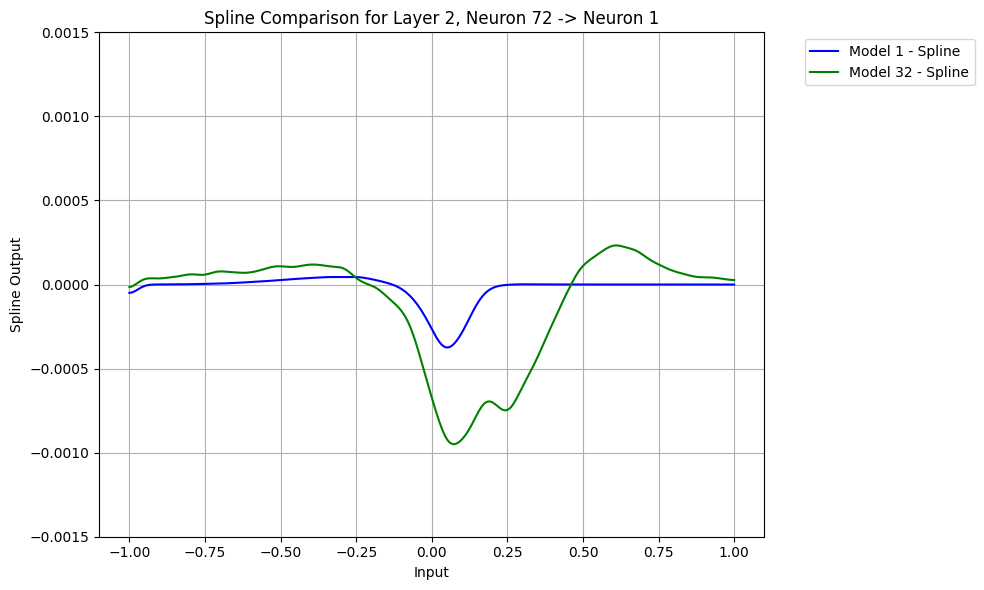

In [6]:
import os

# Definizione della connessione specifica per il confronto
layer_idx = 2  # Indice del layer
in_neuron_idx = 72  # Indice del neurone precedente
out_neuron_idx = 1  # Indice del neurone successivo
grid_range = (-1, 1)  # Range dei valori della griglia

compare_splines_for_neuron(models[0],  models[-1], layer_idx, in_neuron_idx, out_neuron_idx, grid_range=(-1, 1), plot_control_points=False, model_index1=1, model_index2=len(models))

In [7]:
find_max_excursion(models[-1], grid_range=(-1, 1))

(2, 72, 1, 0.0011819013542388177)

In [8]:
#find_max_excursion(models[1], grid_range=(-1, 1))

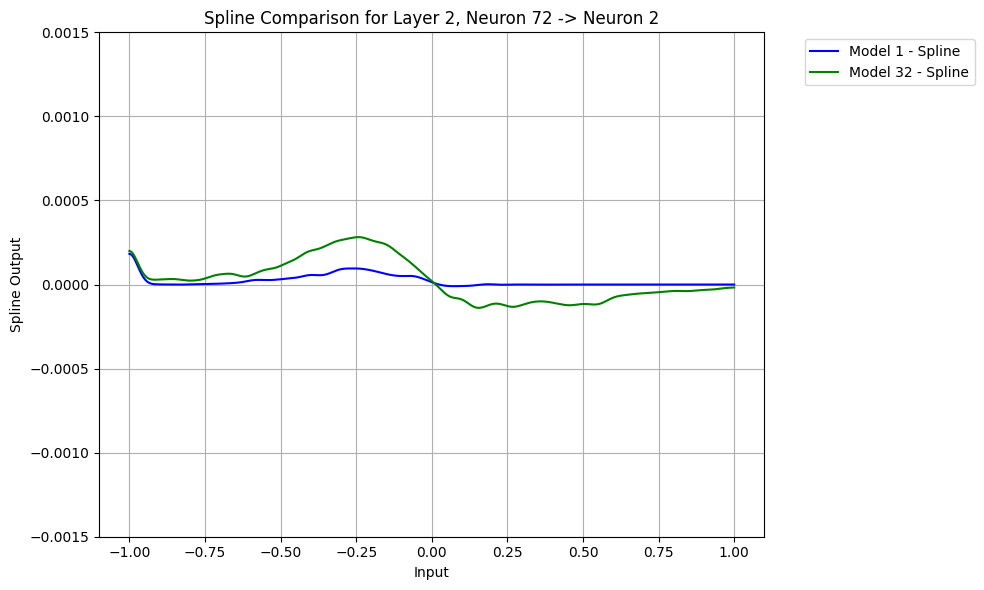

In [9]:
# Definizione della connessione specifica per il confronto
layer_idx = 2  # Indice del layer
in_neuron_idx = 72  # Indice del neurone precedente
out_neuron_idx = 2  # Indice del neurone successivo
grid_range = (-1, 1)  # Range dei valori della griglia

compare_splines_for_neuron(models[0],  models[-1], layer_idx, in_neuron_idx, out_neuron_idx, grid_range=(-1, 1), plot_control_points=False, model_index1=1, model_index2=len(models))

In [12]:
table = print_statistics_table(models, grid_range=(-1, 1))

Calcolo delle statistiche per il modello 1/32...
Calcolo delle statistiche per il modello 2/32...
Calcolo delle statistiche per il modello 3/32...
Calcolo delle statistiche per il modello 4/32...
Calcolo delle statistiche per il modello 5/32...
Calcolo delle statistiche per il modello 6/32...
Calcolo delle statistiche per il modello 7/32...
Calcolo delle statistiche per il modello 8/32...
Calcolo delle statistiche per il modello 9/32...
Calcolo delle statistiche per il modello 10/32...
Calcolo delle statistiche per il modello 11/32...
Calcolo delle statistiche per il modello 12/32...
Calcolo delle statistiche per il modello 13/32...
Calcolo delle statistiche per il modello 14/32...
Calcolo delle statistiche per il modello 15/32...
Calcolo delle statistiche per il modello 16/32...
Calcolo delle statistiche per il modello 17/32...
Calcolo delle statistiche per il modello 18/32...
Calcolo delle statistiche per il modello 19/32...
Calcolo delle statistiche per il modello 20/32...
Calcolo d